In [1]:
import os
import cv2
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from utilities import *

## Load data

In [2]:
train_df = get_path_images("face_croped/train")
val_df = get_path_images("face_croped/val")
test_df = get_path_images("face_croped/test")

In [3]:
folder_tree("face_croped")

face_croped/
    test/
        live/
        spoof/
    train/
        live/
        spoof/
    val/
        live/
        spoof/


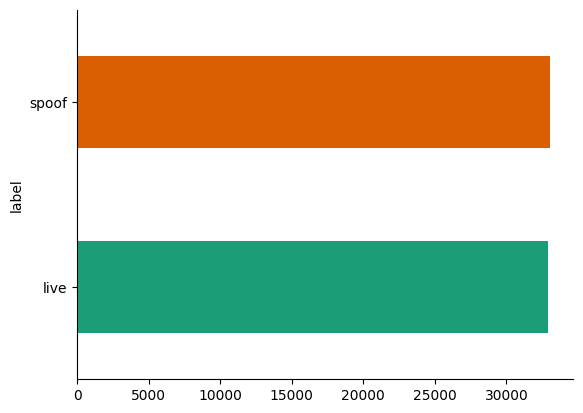

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

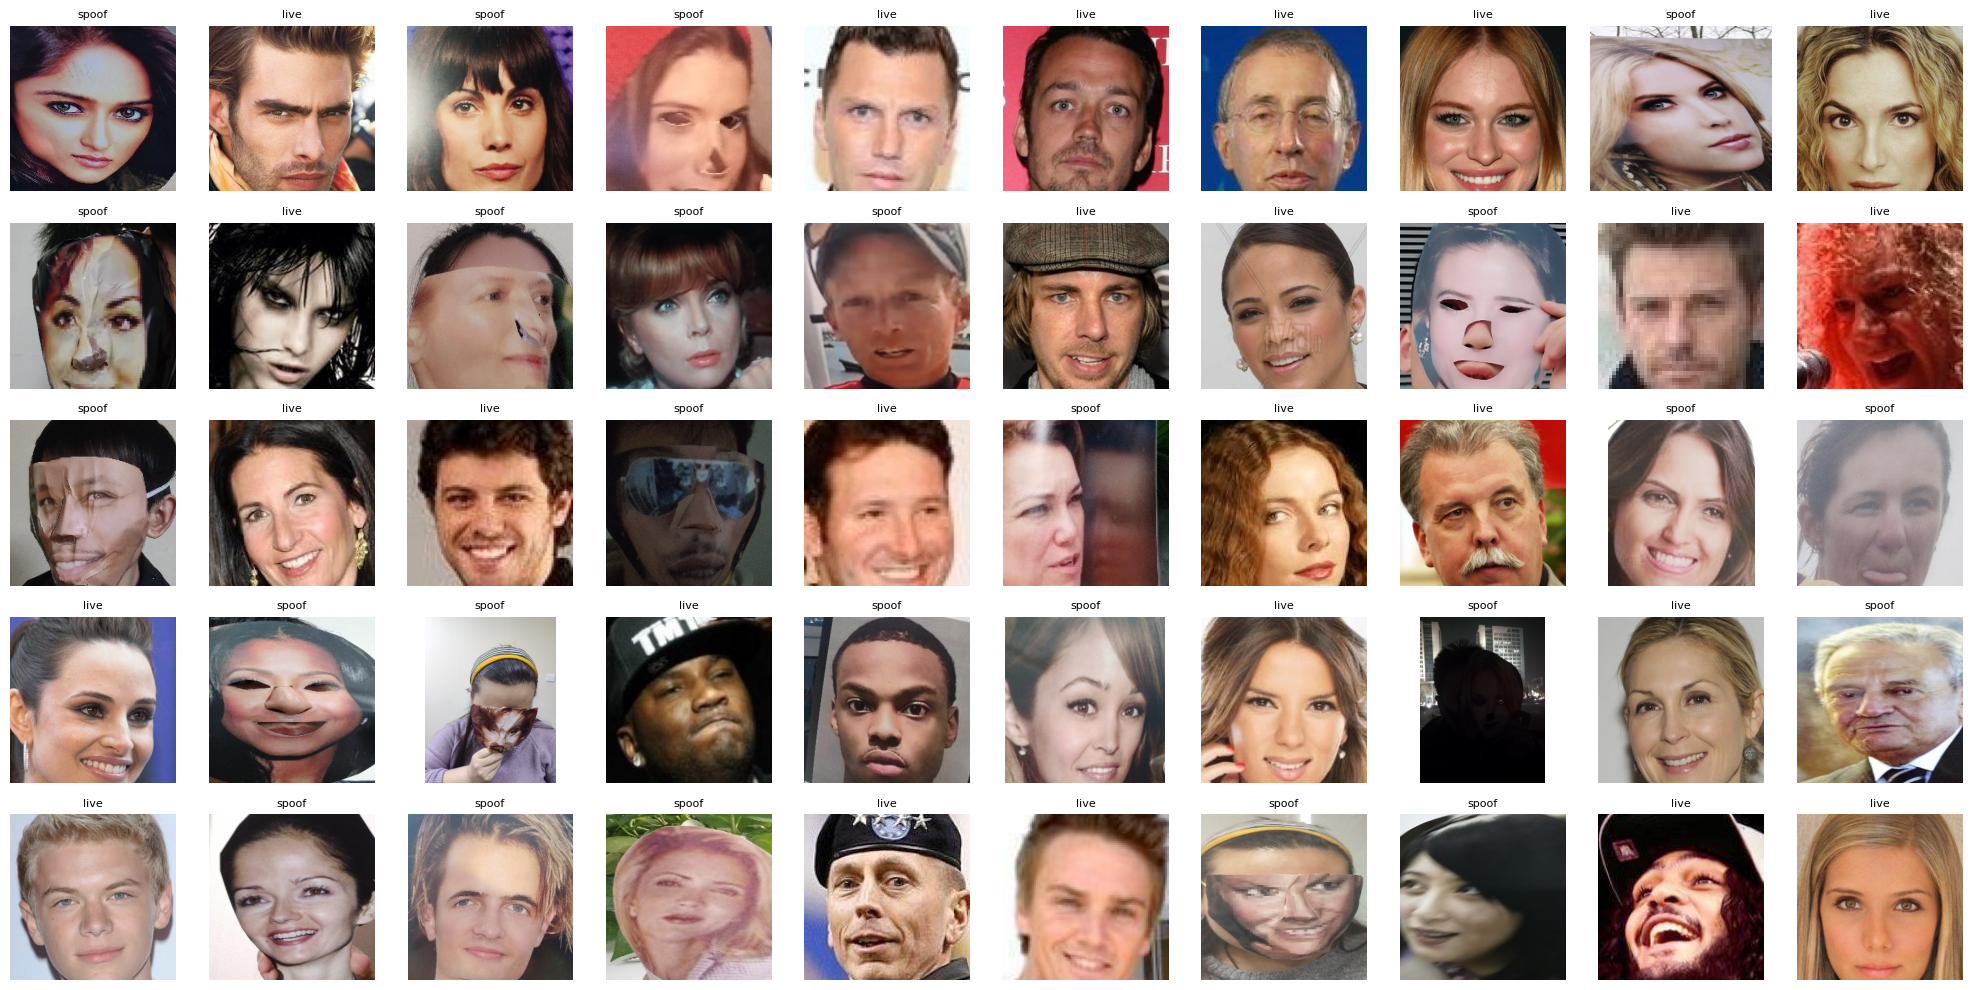

In [5]:
visualize_data(train_df, base_dir = "face_croped/train", rows=5, cols=10)

In [6]:
# Define a mapping from string labels to integers
label_mapping = {'live': 0, 'spoof': 1}

# Apply the mapping to your dataframe labels
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.dataframe.iloc[idx, 0])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        label = self.dataframe.iloc[idx, 1]  # label is now an integer, either 0 or 1

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)
        # print(image.shape)
        # print(label.shape)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


In [8]:
train_data = CustomImageDataset(dataframe=train_df, base_dir="face_croped/train", transform=transform)
val_data = CustomImageDataset(dataframe=val_df, base_dir="face_croped/val", transform=transform)


# # Create a DataLoader
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=True, pin_memory=True)

In [9]:
from torchvision.models import mobilenet_v2
import torch.nn as nn

In [10]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Custom classifier to replace the top of the MobileNetV2
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1280, 8)  # 1280 is the output features of MobileNetV2
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [ ]:
# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Modify the first layer to accept 1-channel input
first_conv_layer = mobilenet.features[0][0]
mobilenet.features[0][0] = nn.Conv2d(1, first_conv_layer.out_channels,
                                     kernel_size=first_conv_layer.kernel_size,
                                     stride=first_conv_layer.stride,
                                     padding=first_conv_layer.padding,
                                     bias=False)

# Modify the classifier part of MobileNetV2 (if necessary)
mobilenet.classifier = CustomClassifier()

In [12]:
input_tensor = torch.randn(1, 1, 224, 224)
output = mobilenet(input_tensor)
print(output)
print(output.shape)

tensor([[0.5470]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 1])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
mobilenet

In [15]:
model = mobilenet.to(device)

# Define the loss function
criterion = nn.BCELoss()

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
from torchmetrics import Accuracy, Recall, F1Score

def train_and_validate(model, num_epochs, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, save_path):
    # Initialize metric objects from torchmetrics
    train_accuracy = Accuracy(task='binary').to(device)
    train_recall = Recall(average='macro', num_classes=2, task='multiclass').to(device)
    train_f1 = F1Score(average='macro', num_classes=2, task='multiclass').to(device)
    val_accuracy = Accuracy(task='binary').to(device)
    val_recall = Recall(average='macro', num_classes=2, task='multiclass').to(device)
    val_f1 = F1Score(average='macro', num_classes=2, task='multiclass').to(device)

    # Initialize dictionary to store metrics history
    metrics_history = {
        'train_accuracy': [],
        'train_recall': [],
        'train_f1': [],
        'train_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_f1': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Reset the metrics for each epoch
        train_accuracy.reset()
        train_recall.reset()
        train_f1.reset()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            # print(inputs.shape)
            # print(labels.shape)
            outputs = model(inputs)
            # print(outputs.shape)
            outputs = outputs.squeeze()
            # print(outputs.shape)

            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            # print(outputs.argmax(1))
            # print(labels.shape)
            # Update metrics with current batch
            train_accuracy.update(outputs, labels)
            train_recall.update(outputs, labels)
            train_f1.update(outputs, labels)


        if (epoch + 1) % 50 == 0:
          torch.save(model, f"{save_path}/model_{epoch + 1}.pth")
          print(f'Model saved after epoch {epoch+1}')


        scheduler.step()

        # Compute metrics for the training dataset
        metrics_history['train_accuracy'].append(train_accuracy.compute().item())
        metrics_history['train_recall'].append(train_recall.compute().item())
        metrics_history['train_f1'].append(train_f1.compute().item())
        metrics_history['train_loss'].append(running_loss / len(train_dataloader.dataset))

        # Validation phase
        model.eval()
        running_loss = 0.0

        # Reset validation metrics
        val_accuracy.reset()
        val_recall.reset()
        val_f1.reset()

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                outputs = outputs.squeeze()
                labels = labels.float()

                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                # Update metrics with current batch
                val_accuracy.update(outputs, labels)
                val_recall.update(outputs, labels)
                val_f1.update(outputs, labels)

        # Compute metrics for the validation dataset
        metrics_history['val_accuracy'].append(val_accuracy.compute().item())
        metrics_history['val_recall'].append(val_recall.compute().item())
        metrics_history['val_f1'].append(val_f1.compute().item())
        metrics_history['val_loss'].append(running_loss / len(val_dataloader.dataset))

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {metrics_history["train_loss"][-1]:.4f}, '
              f'Train accuracy: {metrics_history["train_accuracy"][-1]:.4f}, '
              f'Train recall: {metrics_history["train_recall"][-1]:.4f}, '
              f'Train f1: {metrics_history["train_f1"][-1]:.4f} - '
              f'Val Loss: {metrics_history["val_loss"][-1]:.4f}, '
              f'Val accuracy: {metrics_history["val_accuracy"][-1]:.4f}, '
              f'Val recall: {metrics_history["val_recall"][-1]:.4f}, '
              f'Val f1: {metrics_history["val_f1"][-1]:.4f}')

    return metrics_history

In [ ]:
epochs = 100 
metrics = train_and_validate(
    model=model,
    num_epochs=epochs,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_path = 'results'
)

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, metrics.get("train_accuracy"), label='Training Accuracy')
plt.plot(epochs, metrics.get("val_accuracy"), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


In [ ]:
# Plotting f1
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, metrics.get("train_loss"), label='Training Loss')
plt.plot(epochs, metrics.get("val_loss"), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()


In [ ]:
# Plotting Accuracy
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, metrics.get("train_f1"), label='Training F1')
plt.plot(epochs, metrics.get("val_f1"), label='Validation F1')
plt.title('Training and Validation f1')
plt.legend()

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, metrics.get("train_recall"), label='Training recall')
plt.plot(epochs, metrics.get("val_recall"), label='Validation recall')
plt.title('Training and Validation recall')
plt.legend()